# Verkkoteoria 10.2.2025

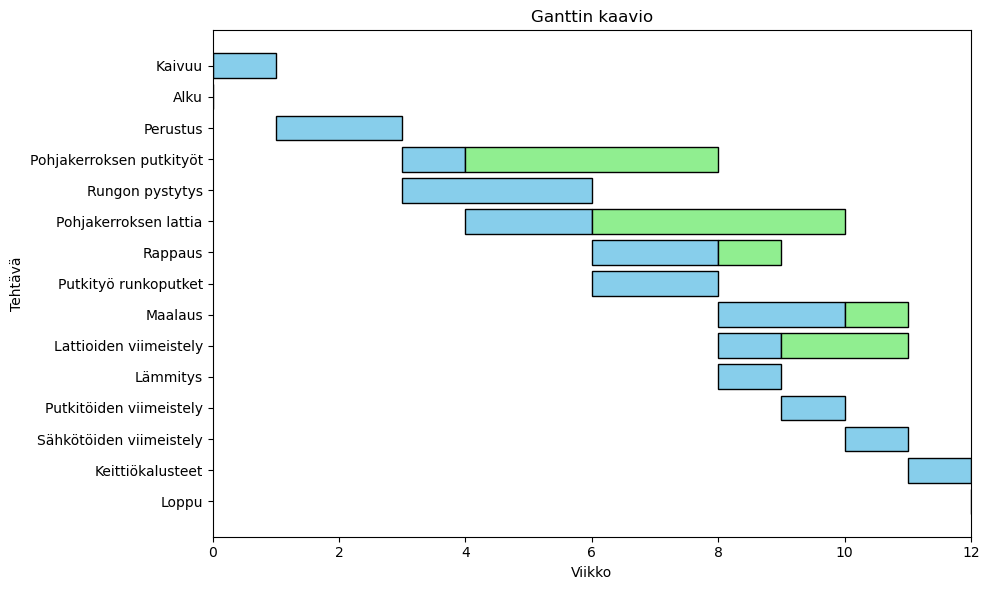

,Tehtava,Te,Tl,Me,Ml,Pelivara
0,Alku,0,0,0,0,0
1,Kaivuu,0,1,0,1,0
2,Perustus,1,3,1,3,0
3,Rungon pystytys,3,6,3,6,0
4,Pohjakerroksen putkityöt,3,4,7,8,4
5,Pohjakerroksen lattia,4,6,8,10,4
6,Putkityö runkoputket,6,8,6,8,0
7,Lämmitys,8,9,8,9,0
8,Rappaus,6,8,7,9,1
9,Lattioiden viimeistely,8,9,10,11,2


In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

tehtavat = [
    {"Tehtava": "Alku", "Edeltajat": [], "Kesto": 0},
    {"Tehtava": "Kaivuu", "Edeltajat": ["Alku"], "Kesto": 1},
    {"Tehtava": "Perustus", "Edeltajat": ["Kaivuu"], "Kesto": 2},
    {"Tehtava": "Rungon pystytys", "Edeltajat": ["Perustus"], "Kesto": 3},
    {"Tehtava": "Pohjakerroksen putkityöt", "Edeltajat": ["Perustus"], "Kesto": 1},
    {"Tehtava": "Pohjakerroksen lattia", "Edeltajat": ["Pohjakerroksen putkityöt"], "Kesto": 2},
    {"Tehtava": "Putkityö runkoputket", "Edeltajat": ["Rungon pystytys"], "Kesto": 2},
    {"Tehtava": "Lämmitys", "Edeltajat": ["Putkityö runkoputket"], "Kesto": 1},
    {"Tehtava": "Rappaus", "Edeltajat": ["Rungon pystytys"], "Kesto": 2},
    {"Tehtava": "Lattioiden viimeistely", "Edeltajat": ["Pohjakerroksen lattia", "Rappaus"], "Kesto": 1},
    {"Tehtava": "Putkitöiden viimeistely", "Edeltajat": ["Lämmitys"], "Kesto": 1},
    {"Tehtava": "Maalaus", "Edeltajat": ["Rappaus"], "Kesto": 2},
    {"Tehtava": "Sähkötöiden viimeistely", "Edeltajat": ["Putkitöiden viimeistely"], "Kesto": 1},
    {"Tehtava": "Keittiökalusteet", "Edeltajat": ["Maalaus", "Sähkötöiden viimeistely", "Lattioiden viimeistely"], "Kesto": 1},
    {"Tehtava": "Loppu", "Edeltajat": ["Keittiökalusteet"], "Kesto": 0},
]

tehtava_df = pd.DataFrame(tehtavat)

def laske_aikataulut(tehtava_df):
    G = nx.DiGraph()

    for _, row in tehtava_df.iterrows():
        tehtava = row["Tehtava"]
        kesto = row["Kesto"]
        G.add_node(tehtava, kesto=kesto)
        for edeltaja in row["Edeltajat"]:
            G.add_edge(edeltaja, tehtava)

    earliest_start = {}
    earliest_finish = {}
    for node in nx.topological_sort(G):
        es = max((earliest_finish[pred] for pred in G.predecessors(node)), default=0)
        earliest_start[node] = es
        earliest_finish[node] = es + G.nodes[node]["kesto"]

    latest_finish = {node: earliest_finish["Loppu"] for node in G}
    latest_start = {node: latest_finish[node] - G.nodes[node]["kesto"] for node in G}
    for node in reversed(list(nx.topological_sort(G))):
        for succ in G.successors(node):
            latest_finish[node] = min(latest_finish[node], latest_start[succ])
        latest_start[node] = latest_finish[node] - G.nodes[node]["kesto"]

    total_float = {
        node: latest_start[node] - earliest_start[node] for node in G
    }

    return pd.DataFrame({
        "Tehtava": list(G.nodes),
        "Te": [earliest_start[node] for node in G],
        "Tl": [earliest_finish[node] for node in G],
        "Me": [latest_start[node] for node in G],
        "Ml": [latest_finish[node] for node in G],
        "Pelivara": [total_float[node] for node in G],
    })

def piirra_gantt(tehtava_df, aikataulu_df):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sorted_tasks = aikataulu_df.sort_values(by="Te", ascending=False)
    for i, row in sorted_tasks.iterrows():
        ax.barh(
            row["Tehtava"], row["Tl"] - row["Te"], left=row["Te"], color="skyblue", edgecolor="black"
        )
        if row["Pelivara"] > 0:
            ax.barh(
                row["Tehtava"], row["Pelivara"], left=row["Tl"], color="lightgreen", edgecolor="black"
            )

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("Viikko")
    ax.set_ylabel("Tehtävä")
    ax.set_title("Ganttin kaavio")
    plt.tight_layout()
    plt.show()

aikataulu_df = laske_aikataulut(tehtava_df)

piirra_gantt(tehtava_df, aikataulu_df)

aikataulu_df


# Tulkinta

Projektin kokonaisaikataulu on laskettu speksien mukaan.

Projektin lyhin mahdollinen kesto vastaa viimeisen tehtävän, eli "Loppu"-tehtävän, varhaista valmistumisaikaa. 

Tämä antaa selkeän kuvan projektin minimiajasta ja auttaa suunnittelemaan resurssien käyttöä tehokkaasti. 

Jokaiselle tehtävälle on laskettu varhainen aloitusaika (Te) ja varhainen lopetusaika (Tl), jotka kertovat, milloin tehtävä voidaan aloittaa ja päättää viivästyttämättä muita tehtäviä.

Pelivarojen laskenta paljastaa, kuinka paljon yksittäisten tehtävien aloitusta tai lopetusta voidaan viivästyttää ilman, että se vaikuttaa projektin kokonaisaikatauluun. 

Ganttin kaaviossa pelivaralliset tehtävät on merkitty vihreillä palkkeilla varsinaisten tehtäväpalkkien jälkeen. 

Tämä tuo esiin projektin joustovaran ja mahdollisuudet hallita aikatauluja tehokkaammin. 

Kriittisen polun tehtävät ovat ne, joilla ei ole pelivaraa, ja ne määrittävät projektin aikataulun. Näiden tehtävien eteneminen täytyy varmistaa, jotta koko projekti valmistuu ajallaan. K

aaviossa kriittinen polku erottuu selvästi, koska sen tehtävillä ei ole vihreitä pelivaraosuuksia.

Keittiökalusteiden asennus voi alkaa varhaisimmillaan viikolla 7, kun sen edellyttämät tehtävät, kuten maalaus, sähkötöiden viimeistely ja lattioiden viimeistely, ovat valmistuneet. 

Asennus on kuitenkin suoritettava viimeistään viikolla 8, jotta projektin kokonaisaikataulu pysyy suunnitellussa. 

Eri värit selkeyttävät kaaviota: 

Sininen kuvastaa tehtävien kestoa ja vihreä pelivaroja. 
